In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
from collections import deque

Part 1: Create example

In [2]:
n=64
t = np.linspace(0, 2*np.pi, n, endpoint=False)

In [3]:
r = 100
antennas=[]
x = list(r * np.cos(t))
y = list(r * np.sin(t))
antennas.append(x)
antennas.append(y)

In [4]:
def circularPlacement(n,r):
    elements=[]
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    x = list(r * np.cos(t))
    y = list(r * np.sin(t))
    elements.append(x)
    elements.append(y)
    return elements

In [5]:
def eucDist(A,B):
    return float(np.power(np.power(A[0]-B[0],2)+np.power(A[1]-B[1],2),0.5))

In [6]:
def computeCovRatio(antennas,users,rad_antenna):
    ref=[antennas[0][0],antennas[1][0]]
    counter=0
    for i in range(len(users[0])):
        val=[users[0][i], users[1][i]]
        if eucDist(ref,val)<=rad_antenna:
            counter+=1
    return counter/float(len(users[0]))            

In [7]:
def buildScenario(n_antennas,n_users,rad_antenna,target_covratio,step=1):
    antennas = circularPlacement(n_antennas,rad_antenna/2.0)
    r_users = np.linspace(0, 2*rad_antenna, int(np.ceil(2*rad_antenna/float(step))))
    found = False
    first = True
    for r in r_users:
        users = circularPlacement(n_users,r)
        cov_ratio = computeCovRatio(antennas,users,rad_antenna)
        if cov_ratio<=target_covratio:
            found = True
            break
    if not found:
        return None, None
    return antennas, users

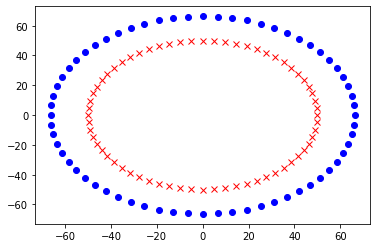

In [8]:
n_antennas=64
n_users=64
rad_antenna=100
target_covratio = 0.66

antennas, users = buildScenario(n_antennas,n_users,rad_antenna,target_covratio,step=1)
plt.plot(antennas[0],antennas[1],'rx',users[0],users[1],'bo')

Part 2 - Create grid JSON file

In [9]:
base_json_general= {
		"resolution[s]": 60,
		"num_steps": 2880,
        "skip": 1440
	}
base_json_options={
		"A": {
			"split_FH": 0,
			"split_MH": 0,
			"DU": 0,
			"CU": 0
		},
		"B_2": {
			"split_FH": 2,
			"split_MH": 2,
			"DU": 0,
			"CU": 2
		},
		"B_4": {
			"split_FH": 4,
			"split_MH": 4,
			"DU": 0,
			"CU": 2
		},
		"C_2": {
			"split_FH": 7.2,
			"split_MH": 2,
			"DU": 1,
			"CU": 2
		},
		"C_4": {
			"split_FH": 7.2,
			"split_MH": 4,
			"DU": 1,
			"CU": 2
		},
		"D_7.2": {
			"split_FH": 7.2,
			"split_MH": 0,
			"DU": 2,
			"CU": 2
		},
		"E_2": {
			"split_FH": 2,
			"split_MH": 2,
			"DU": 0,
			"CU": 1
		},
		"E_4": {
			"split_FH": 4,
			"split_MH": 4,
			"DU": 0,
			"CU": 1
		},
		"F": {
			"split_FH": 7.2,
			"split_MH": 0,
			"DU": 1,
			"CU": 1
		}
	}

In [10]:
base_json_antenna={
			"type": "micro",
			"coord": {
				"x": 0,
				"y": 0
			},
			"params": {
				"capacity[Gb/s]": 1.5,
				"powerMax[dBm]": 43,
				"radius[m]": 100,
				"peakRate[Gb/s]": 0.15,
				"bandwidth[MHz]": 100,
				"refBandwidth[MHz]": 20,
				"nLayers": 8,
				"nRefLayers": 6,
				"ModulationOrder": 8,
				"refModulationOrder": 2,
				"signalingBitrate[Gb/s]": 0.016,
				"nSubcarrers": 6000,
				"nSymbols": 14,
				"nIQbits": 10,
				"MACinformation[Gb/s]": 120,
				"constant": 2000

			},
			"active": 1,
			"option": "None"
 
}

options=["F"]*n_antennas
active=[1]*n_antennas

In [11]:
antennas_dict={}
all_ids=list(range(n_antennas))
all_ids=["a"+str(i) for i in all_ids]

for i in range(n_antennas):
    id_ant=all_ids[i]
    antennas_dict[id_ant]=copy.deepcopy(base_json_antenna)
    antennas_dict[id_ant]["coord"]["x"]=antennas[0][i]
    antennas_dict[id_ant]["coord"]["y"]=antennas[1][i]
    antennas_dict[id_ant]["active"]=active[i]
    antennas_dict[id_ant]["option"]=options[i]
    items = deque(all_ids)
    items.rotate(-i)
    items.popleft()
    neighbor=[]
    sense=-1
    while len(items)>0:
        if sense==-1:
            neighbor.append(items.popleft())
            sense=1
        else:
            neighbor.append(items.pop())
            sense=-1
    antennas_dict[id_ant]["neighbor"]=neighbor

In [12]:
base_json_grid={
		"mode": "auto",
		"components":[],
		"coord_x":[],
		"coord_y":[],
		"components_list": [{
			"profile_mean": "/input/profiles/profile2.csv",
			"profile_var": 0.1,
			"profile_min": 0.1,
			"profile_max": 1,
			"shift_max": 0,
			"period": 1440,
			"noise": 0.05,
			"interpl": "spline"
		}]
	}

In [13]:
grid_dict=copy.deepcopy(base_json_grid)
grid_dict["components"]=[0]*64
grid_dict["coord_x"]=users[0]
grid_dict["coord_y"]=users[1]

In [14]:
example_dict={"general":base_json_general,"options":base_json_options,"grid":grid_dict,"antennas":antennas_dict}

In [15]:
with open("scenario_1_F.json", "w") as outfile:
    json.dump(example_dict, outfile)